<a href="https://colab.research.google.com/github/sakibchowdhury131/railcop/blob/main/__DFT%2BCNN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 4.4 kB/s 
     |████████████████████████████████| 454 kB 64.0 MB/s 
     |████████████████████████████████| 2.9 MB 35.4 MB/s 
     |████████████████████████████████| 3.0 MB 46.4 MB/s 


In [2]:
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(1)

In [3]:
import os
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import pandas as pd

In [4]:
label0 = pd.read_csv('/content/drive/MyDrive/RailCop/New Files/Sakib/data/label0/Copy of train_1.csv')
label1 = pd.read_csv('/content/drive/MyDrive/RailCop/New Files/Sakib/data/label1/Copy of train_1.csv')
print(label1)

      Sensor1  Sensor2  ...  Sensor2+Sensor4  Sensor1+Sensor2+Sensor3
0           2        9  ...               10                       12
1           4        9  ...                9                       13
2           4        9  ...               11                       15
3           4       11  ...               12                       16
4           2        9  ...               10                       12
...       ...      ...  ...              ...                      ...
5384        3        9  ...               10                       13
5385        3       10  ...               11                       14
5386        4        8  ...                9                       13
5387        3        9  ...               10                       13
5388        3       10  ...               12                       15

[5389 rows x 7 columns]


In [5]:
__fullVector0 = label0['Sensor1+Sensor2+Sensor3'].to_numpy()
__fullVector1 = label1['Sensor1+Sensor2+Sensor3'].to_numpy()


print(__fullVector0.shape)
print(__fullVector1.shape)


(23050,)
(5389,)


In [78]:
__frameSize = 10

## label 0 framing

__numFrames0 = int(__fullVector0.shape[0] / __frameSize)
__frames0 = np.zeros((__numFrames0,__frameSize))
for i in range (0, __numFrames0):
  for j in range (0, __frameSize):
    __frames0[i][j] = __fullVector0[i*__frameSize+j]

In [79]:
## label 1 framing

__numFrames1 = int(__fullVector1.shape[0] / __frameSize)
__frames1 = np.zeros((__numFrames1,__frameSize))
for i in range (0, __numFrames1):
  for j in range (0, __frameSize):
    __frames1[i][j] = __fullVector1[i*__frameSize+j]

In [80]:
__frames0.shape

(2305, 10)

In [81]:
__frames1.shape

(538, 10)

In [82]:
__maxFrames = __frames1.shape[0]
__label0 = __frames0[0:__maxFrames, :]
__label1 = __frames1[0:__maxFrames, :]

In [83]:
Y0 = np.zeros(__label0.shape[0])
Y1 = np.ones(__label1.shape[0])
print(Y0.shape)
print(Y1.shape)

(538,)
(538,)


In [84]:
## Applying DFT
## finding Fourier Co-efficients Xn

def get_xn(samples,n):
    L  = len(samples)
    ks = np.arange(0,L,1)
    xn = np.sum(samples*np.exp((1j*2*np.pi*ks*n)/L))/L
    return(xn)

In [85]:
## Compute Fourier coefficients only up to the Nyquest Limit Xn, n=1,...,L/2 and 
## multiply the absolute value of the Fourier coefficients by 2, to account for 
## the symetry of the Fourier coefficients above the Nyquest Limit.


def get_xns(samples):
    mag = []
    L = len(samples)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(get_xn(samples,n))*2)
    return(mag)
mag = get_xns(__frames1[0])

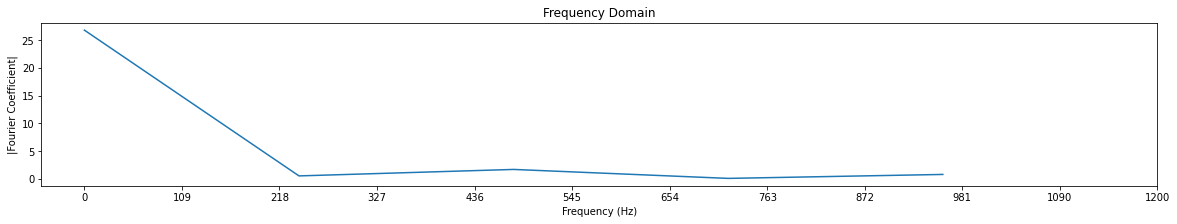

In [92]:
## Fourier Plot 

def get_Hz_scale_vec(ks,sample_rate,Npoints):
    freq_Hz = ks*sample_rate/Npoints
    freq_Hz  = [int(i) for i in freq_Hz ] 
    return(freq_Hz )
Nxlim = 12
sample_rate = int(9600/4)
ks   = np.linspace(0,len(mag),Nxlim)
ksHz = get_Hz_scale_vec(ks,sample_rate,len(__frames1[0]))

plt.figure(figsize=(20,3))
plt.plot(mag)
plt.xticks(ks,ksHz)
plt.title("Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Fourier Coefficient|")
plt.show()

In [93]:
## Fourier coefficients of label0 
__fourier0 = np.zeros((__maxFrames,len(mag)))
for i in range(0, __maxFrames):
  __fourier0[i] = np.array(get_xns(__label0[i]))



## Fourier coefficients of label1 
__fourier1 = np.zeros((__maxFrames,len(mag)))
for i in range(0, __maxFrames):
  __fourier1[i] = np.array(get_xns(__label1[i]))

In [94]:
X = np.asarray(np.concatenate((__fourier0, __fourier1), axis = 0), dtype=np.float32)
Y = np.asarray(np.concatenate((Y0, Y1), axis = 0), dtype = np.float32)
print(X.shape)
print(Y.shape)

(1076, 5)
(1076,)


In [95]:
from sklearn.utils import shuffle
X, Y = shuffle(X,Y)

In [96]:
X.shape

(1076, 5)

In [98]:
def network():
  __input = keras.Input((X.shape[1], 1))
  __conv1 = keras.layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu')(__input)
  __conv2 = keras.layers.Conv1D(filters = 16, kernel_size = 3, activation = 'relu')(__conv1)
  __dense3 = keras.layers.Dense(16, activation = 'relu')(__conv2)
  __output = keras.layers.Dense(1, activation = 'sigmoid')(__dense3)

  model = keras.Model(inputs = __input, outputs = __output)
  return model 



model = network()
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 3, 16)             64        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 16)             784       
_________________________________________________________________
dense_8 (Dense)              (None, 1, 16)             272       
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1)              17        
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
_________________________________________________________________


In [99]:
model.compile(loss='binary_crossentropy',
                      optimizer= 'adam',
                      metrics=['accuracy'])

In [100]:
__modelVersion = '__timeSeriesTest1.0'

weight_saver = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/RailCop/New Files/Sakib/models/'+__modelVersion, monitor='val_accuracy', 
                                save_best_only=True, save_weights_only=False, mode= 'max')

annealer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001,mode= 'min')


hist = model.fit( x = X , 
                  y = Y, 
                  batch_size = 64,
                  epochs = 600,
                  callbacks = [weight_saver , annealer],
                  validation_split = 0.2,
                  shuffle = True,
                  verbose = 1)

Epoch 1/600
14/14 [==============================] - 1s 96ms/step - loss: 0.6942 - accuracy: 0.5058 - val_loss: 0.6908 - val_accuracy: 0.5463 - lr: 0.0010
Epoch 2/600
14/14 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.5326 - val_loss: 0.6938 - val_accuracy: 0.4861 - lr: 0.0010
Epoch 3/600
14/14 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.5023 - val_loss: 0.6893 - val_accuracy: 0.5231 - lr: 0.0010
Epoch 4/600
14/14 [==============================] - 2s 109ms/step - loss: 0.6910 - accuracy: 0.5221 - val_loss: 0.6902 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 5/600
14/14 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5326 - val_loss: 0.6918 - val_accuracy: 0.5046 - lr: 0.0010
Epoch 6/600
14/14 [==============================] - 0s 7ms/step - loss: 0.6891 - accuracy: 0.5349 - val_loss: 0.6923 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 7/600
14/14 [==============================] - 0s 6ms/step - loss: 